In [1]:
# Install JAX + jaxlib for GPU (CUDA 11)
!pip install --upgrade pip
!pip install "jax[cuda11_local]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install keras-core

Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html


In [2]:
import os
os.environ["KERAS_BACKEND"] = "jax"

In [3]:
# Package Imports

import sklearn as sk
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

from  matplotlib.colors import LinearSegmentedColormap

from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.dummy import DummyRegressor

import itertools

import keras_core as keras
from keras_core import layers

print("Using keras-core:", keras.__name__)

Using JAX backend.
Using keras-core: keras_core


Cite your source of data. (Remember to include your data as a comma separated value (CSV) file with your submission.

In [4]:
# Import dataset
df = pl.read_csv("project1_2008_all.csv")

# Read more csv's and concatenate (Optional)
df2 = pl.read_csv("project1_2009_all.csv")
df = pl.concat([df, df2])

# Add goal_differential column to the dataframe
df = df.with_columns(
    (pl.col("goals_scored") - pl.col("goals_allowed")).alias("goal_differential")
)

# Convert 'col1' from float64 to int16 Future opitmization
# df = df.with_columns([
#     pl.col('goals_scored').cast(pl.Int16),  # Cast column from float64 to int16
# ])

df

match_id,team_id,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,goals_scored,goals_allowed,goal_differential
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64
220071,362,48,34,16,25,29,16,13,44,51,50,60,20,105,35,22,16,72,68,221,19,45,29,19,15,34,43,54,16,23,23,14,18,20,20,24,15,12,42,37,96,23,16,32,39,35,15,18,20,20,15,16,16,61,66,65,2.0,1.0,1.0
220071,367,110,101,39,48,79,63,52,78,18,11,186,62,71,112,88,70,120,21,14,64,72,116,89,70,100,22,14,65,59,55,61,53,23,15,69,57,67,62,23,14,81,70,91,17,10,55,75,19,15,56,21,12,19,14,13,1.0,2.0,-1.0
220074,370,14,16,39,31,14,16,30,54,13,17,48,8,19,11,18,19,19,8,18,2,17,14,15,17,16,8,16,20,2,8,20,110,12,7,15,21,37,36,12,22,39,15,14,8,15,21,20,9,20,43,13,22,17,21,11,1.0,2.0,-1.0
220074,363,14,10,20,17,3,14,20,8,19,18,55,85,90,38,15,23,39,62,18,124,53,34,8,11,33,48,9,76,18,16,26,23,39,20,45,14,23,43,61,19,3,5,33,38,4,18,8,17,12,11,26,22,36,9,21,2.0,1.0,1.0
220070,359,36,46,38,44,20,33,37,11,41,25,56,47,56,32,31,44,11,50,39,75,161,72,91,102,16,162,133,76,32,57,56,12,71,59,74,106,132,15,163,123,30,54,7,70,50,55,10,86,74,15,98,75,11,13,125,2.0,0.0,2.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
272481,3611,5,7,8,13,25,14,27,42,6,8,25,27,17,21,26,16,27,8,17,35,21,25,32,24,35,14,25,23,28,35,24,37,15,26,24,27,26,36,10,19,49,38,50,15,23,32,45,12,23,51,10,19,15,30,14,4.0,0.0,4.0
285809,4398,1,3,3,1,1,1,1,1,1,1,1,2,3,1,1,1,1,1,1,3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0.0,1.0,-1.0
285809,4860,1,1,1,1,1,1,1,1,1,1,13,12,9,4,3,1,1,1,1,12,9,4,3,1,1,1,1,8,4,3,1,1,1,1,3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1.0,0.0,1.0


In [5]:
# Set random state
random_state = 999

# Set random seeds for libraries
np.random.seed(random_state)
keras.random.SeedGenerator(seed=random_state)

# Filter out rows where 'goal_differential' is NaN or null
original_rows = df.shape[0]
df = df.filter(
    pl.col("goal_differential").is_not_null()
    & pl.col("goal_differential").is_finite()
)
rows_removed = original_rows - df.shape[0]
print(f"Rows removed from df after filtering NaN: {rows_removed}")

# Filter the dataframe to only take certain rows based on team id (Optional)
#   This would be beneficial if we only want to train our model
#   on only teams from a certain league or set of leagues
premier_league_teams: list[int] = [
    359, #Arsenal
    362, #Aston Villa
    365, #Blackburn Rovers
    358, #Bolton Wanderers
    365, #Chelsea
    368, #Everton
    370, #Fulham
    306, #Hull City
    364, #Liverpool
    382, #Manchester City
    360, #Manchester United
    369, #Middlesbrough
    361, #Newcastle United
    385, #Portsmouth
    336, #Stoke City
    366, #Sunderland
    367, #Tottenham Hotspur
    383, #West Bromwich Albion
    371, #West Ham United
    350, #Wigan Athletic
]
bundesliga_teams: list[int] = [
    138, #Wolfsburg
    132, #Bayern Munich
    134, #Struttgart
    129, #Hertha Berlin
    127, #Hamburg SV
    124, #Dortmund
    7911, #Hoffenheim
    133, #Schalke
    131, #Bayer Leverkusen
    137, #Werder Bremen
    2428, #Hannover
    125, #Eintracht Frankfurt
    121, #Bochum
    268, #B. Monchengladbach
    123, #Cottbus
    4471, #Karlsruher
    2506, #Arminia Bielefeld
]
la_liga_teams: list[int] = [
    6832, #Almeria
    5545, #Althletic Bilbao
    1068, #Atletico Madrid
    83, #Barcelona
    244, #Betis
    90, #Deportive de la Coruna
    88, #Espanyol
    2922, #Getafe
    99, #Malaga
    84, #Mallorca
    100, #Numancia
    97, #Osasuna
    87, #Racing Santender
    86, #Real Madrid
    2571, #Recreativo Huelva
    243, #Sevilla
    3788, #Sporting Gijon
    94, #Valencia
    95, #Real Valladolid
    102, #Villarreal
]
serie_a_teams: list[int] = [
    105, #Atalanta
    107, #Bologna
    2925, #Cagliari
    3257, #Catania
    238, #Chievo Verona
    109, #Fiorentina
    3263, #Genoa
    110, #Internazionale
    111, #Juventus
    112, #Lazio
    113, #Lecce
    103, #Mila
    114, #Napoli
    2923, #Palermo
    117, #Regina
    104, #Roma
    2734, #Sampdoria
    2735, #Siena
    239, #Torino
    118, #Udinese
]

ligue_1_teams: list[int] = [
    172, #Auxerre
    159, #Bordeaux
    2927, #Caen
    6994, #Grenoble
    3236, #Le Havre AC
    2697, #Le Mans
    166, #Lille
    273, #Lorient
    167, #Lyon
    176, #Marseille
    174, #Monaco
    3267, #Nancy
    165, #Nantes
    2502, #Nice
    160, #PSG
    10677, #Rennes
    178, #Saint-Etienne
    272, #Sochaux
    179, #Toulouse
    6732, #Valenciennes
]

# Filter the dataframe to only include teams from the top 5 leagues
df = df.filter(
    pl.col("team_id").is_in(
        premier_league_teams + bundesliga_teams + la_liga_teams + serie_a_teams + ligue_1_teams
    )
)


df

Rows removed from df after filtering NaN: 40


match_id,team_id,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,goals_scored,goals_allowed,goal_differential
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64
220071,362,48,34,16,25,29,16,13,44,51,50,60,20,105,35,22,16,72,68,221,19,45,29,19,15,34,43,54,16,23,23,14,18,20,20,24,15,12,42,37,96,23,16,32,39,35,15,18,20,20,15,16,16,61,66,65,2.0,1.0,1.0
220071,367,110,101,39,48,79,63,52,78,18,11,186,62,71,112,88,70,120,21,14,64,72,116,89,70,100,22,14,65,59,55,61,53,23,15,69,57,67,62,23,14,81,70,91,17,10,55,75,19,15,56,21,12,19,14,13,1.0,2.0,-1.0
220074,370,14,16,39,31,14,16,30,54,13,17,48,8,19,11,18,19,19,8,18,2,17,14,15,17,16,8,16,20,2,8,20,110,12,7,15,21,37,36,12,22,39,15,14,8,15,21,20,9,20,43,13,22,17,21,11,1.0,2.0,-1.0
220070,359,36,46,38,44,20,33,37,11,41,25,56,47,56,32,31,44,11,50,39,75,161,72,91,102,16,162,133,76,32,57,56,12,71,59,74,106,132,15,163,123,30,54,7,70,50,55,10,86,74,15,98,75,11,13,125,2.0,0.0,2.0
220070,371,30,60,21,13,49,42,141,16,49,60,33,20,13,32,24,20,9,29,28,24,14,51,40,43,14,52,32,26,22,17,12,8,20,19,14,12,6,6,11,12,30,33,12,46,30,26,15,30,22,10,34,52,11,6,28,0.0,2.0,-2.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
269861,364,402,156,213,10,109,34,92,106,41,94,170,233,10,122,22,105,118,47,107,168,12,116,20,97,111,47,98,12,120,21,156,118,48,100,12,7,6,11,12,10,20,94,62,46,101,16,11,20,20,47,33,78,32,54,45,1.0,0.0,1.0
269809,360,121,121,57,154,158,88,138,138,33,24,168,24,130,190,85,123,114,14,18,55,125,183,105,128,124,36,21,51,57,51,56,58,30,22,144,87,140,138,37,26,125,156,150,34,23,101,99,33,13,147,34,25,44,17,3,5.0,0.0,5.0
269809,350,109,87,80,103,27,15,55,16,17,29,85,78,105,31,19,60,18,18,35,80,85,99,18,59,17,18,33,78,30,18,54,17,18,33,29,18,56,18,18,33,18,30,17,18,31,18,15,15,19,30,17,34,17,18,18,0.0,5.0,-5.0


Set aside 10% of your datapoints as a Test set. This will be used to compare the final performance of
 all the models we train. The remaining 90% of your data will be referred to as your Train/Validation
 dataset.


In [6]:
# Stratify the shuffling based on match_id
#   (This ensures we have no data leakage)
match_ids = df['match_id'].unique()

# Create a gss object to allocate 10% to test set
gss = GroupShuffleSplit(n_splits=1, test_size=0.1, random_state=random_state)
# Split groups based on the criteria of retaining inputs for teams of the same match
train_holdout_idx, test_idx = next(gss.split(df, groups=df['match_id']))

# Split the df based on the indexes from the split
train_holdout_df = df[train_holdout_idx]
test_df = df[test_idx]

# Check percentages
print(f"Train/Holdout shape: {train_holdout_df.shape} ~{train_holdout_df.shape[0]/df.shape[0]*100:.2f}%") # 90%
print(f"Test shape: {test_df.shape} ~{(test_df.shape[0]/df.shape[0]*100):.2f}%") # 10%

# Grab feature rows
X_columns = [f"feature_{i+1}" for i in range(55)]
y_column = ["goal_differential"]

# Set aside final test dataset
X_test, y_test = test_df[X_columns], test_df[y_column] # This is the final test dataset
# train holdout data
X_train_holdout, y_train_holdout = train_holdout_df[X_columns], train_holdout_df[y_column]

Train/Holdout shape: (5272, 60) ~89.92%
Test shape: (591, 60) ~10.08%


Select a method to estimate the value of your error function on new data (Enew). We will be using Option 2: Holdout cross validation, and split the data as follows: 80% train / 20% validate.

In [7]:
gss2 = GroupShuffleSplit(n_splits=1, test_size=20/90, random_state=random_state)
train_idx, holdout_idx = next(gss2.split(train_holdout_df, groups=train_holdout_df['match_id']))
train_df = train_holdout_df[train_idx]
holdout_df = train_holdout_df[holdout_idx]

print(f"Train shape: {train_df.shape} ~{train_df.shape[0]/df.shape[0]*100:.2f}%") # ~70% of total data
print(f"Holdout shape: {holdout_df.shape} ~{holdout_df.shape[0]/df.shape[0]*100:.2f}%") # ~20% of total data

X_train, y_train = train_df[X_columns], train_df[y_column]
X_holdout, y_holdout = holdout_df[X_columns], holdout_df[y_column]

Train shape: (4103, 60) ~69.98%
Holdout shape: (1169, 60) ~19.94%


In [8]:
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()
X_holdout = X_holdout.to_numpy()
y_holdout = y_holdout.to_numpy()
X_test = X_test.to_numpy()
y_test = y_test.to_numpy()


In [9]:
print(X_train[0])
print(y_train[0])

[ 48  34  16  25  29  16  13  44  51  50  60  20 105  35  22  16  72  68
 221  19  45  29  19  15  34  43  54  16  23  23  14  18  20  20  24  15
  12  42  37  96  23  16  32  39  35  15  18  20  20  15  16  16  61  66
  65]
[1.]


In [10]:
# Create a DummyRegressor
dummy_regressor = DummyRegressor(strategy='mean')

# Fit the regressor
dummy_regressor.fit(X_train, y_train)

# Make predictions
y_pred_dummy = dummy_regressor.predict(X_holdout)

# Estimate of E_new
mse_dummy = mean_squared_error(y_holdout, y_pred_dummy)
print(f"Dummy Regressor MSE: {mse_dummy}")

baseline_model = Pipeline([
    ("dummy_regressor", DummyRegressor(strategy='mean'))
])
baseline_model.fit(X_train_holdout, y_train_holdout)

Dummy Regressor MSE: 3.303030709626124


Pipeline(steps=[('dummy_regressor', DummyRegressor())])

 2.2 Train Model Without Dropout / Regularization
 1. Set Up the Data
 • Divide your combined Train/Validation dataset into a training dataset and validation dataset.
 Clearly state what percentages you used for each.
 • Choose an initial batch size.
 2. Set Up the Model
 • Create a model using Keras.
 • Choose an initial loss function for your problem, based on whether you are solving a regression
 or classification problem. Explain why you chose that particular loss function.
 • Choose an initial optimization method (for example, stochastic gradient descent) and learning
 rate (for example, lr = 0.0001). Explain the reasoning behind your choice of optimization
 method.
 3. Train and Compute Validation Loss
 • Train your model. (It may be helpful to use TensorBoard, WandB, or Neptune.ai to visualize the
 training / validation error throughout the training process!)
 • Using the trained model, compute the validation loss on your validation dataset.
 4. Hyperparameter Sweep and Final Model
 • Experiment with different hyperparameters to improve your model’s performance. Examples of
 hyperparameters you can iterate over include:
 – Number of layers
 – Size or shape of each layer
 – Number of epochs
 – Batch size
 – Learning rate
 – Loss function
 – Optimization method
 • Sweep over several hyperparameter combinations and record the Validation Loss. Use the
 recorded validation losses to compare combinations and select the best model.
 • Using your best hyperparameter combination, train a final model (without dropout)

In [11]:
def create_nn(
  input_shape,
  width=64,
  depth=3,
  activation="relu",
  learning_rate=1e-3,
  optimizer_name="adam",
  loss_name="mse",
  dropout=0.0,
  regularization_name=None, #l1, l2, etc.
  regularization_rate=0.0,
):

  # Set optimizer
  if optimizer_name == "sgd":
    optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
  elif optimizer_name == "adam":
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
  else: # Default to Adam
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)


  # Set Regularization
  regularizer = None
  if regularization_name is not None:
    regularizer = keras.regularizers.get(
        {"class_name": regularization_name.upper(), "config": {regularization_name: regularization_rate}}
    )

  # Construct Model
  # Input Layer
  inputs = layers.Input(shape=input_shape)
  # First Hidden Layer
  x = layers.Dense(
      width,
      activation=activation,
      kernel_regularizer=regularizer,
      bias_regularizer=regularizer,
      )(inputs)
  # N-1 more Hidden Layers
  for _ in range(depth-1):
      if dropout > 0.0:
          x = layers.Dropout(dropout)(x) # (Dropout layer, if applicable)
      x = layers.Dense(width, activation=activation)(x)
  # Output Layer
  outputs = layers.Dense(1, activation='linear')(x)
  # Create Model
  modelx = keras.Model(inputs=inputs, outputs=outputs)

  # Compile Model
  modelx.compile(
    optimizer=optimizer,
    loss=loss_name,
    metrics=[],
  )

  return modelx

# Create a default test model
model_test = create_nn(
  X_train.shape[1:]
)
model_test.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 55)                │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense (Dense)                   │ (None, 64)                │      3,584 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_1 (Dense)                 │ (None, 64)                │      4,160 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_2 (Dense)                 │ (None, 64)                │      4,160 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_3 (Dense)                 │ (None, 1)                 │         65 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 11,969 (46.75 KB)

 Trainable params: 11,969 (46.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 138.0460 - val_loss: 9.4726
Epoch 2/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.3618 - val_loss: 6.4321
Epoch 3/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.9727 - val_loss: 5.3132
Epoch 4/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.2841 - val_loss: 4.8824
Epoch 5/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.7719 - val_loss: 4.3851
Epoch 6/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.3427 - val_loss: 4.7843
Epoch 7/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.3239 - val_loss: 4.1060
Epoch 8/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.1109 - val_loss: 4.2512
Epoch 9/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.1028 - val_loss: 3.9940
Epoch 10/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.0185 - val_loss: 4.1101
Epoch 11/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.8475 - val_loss: 3.9176
Epoch 12/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/s

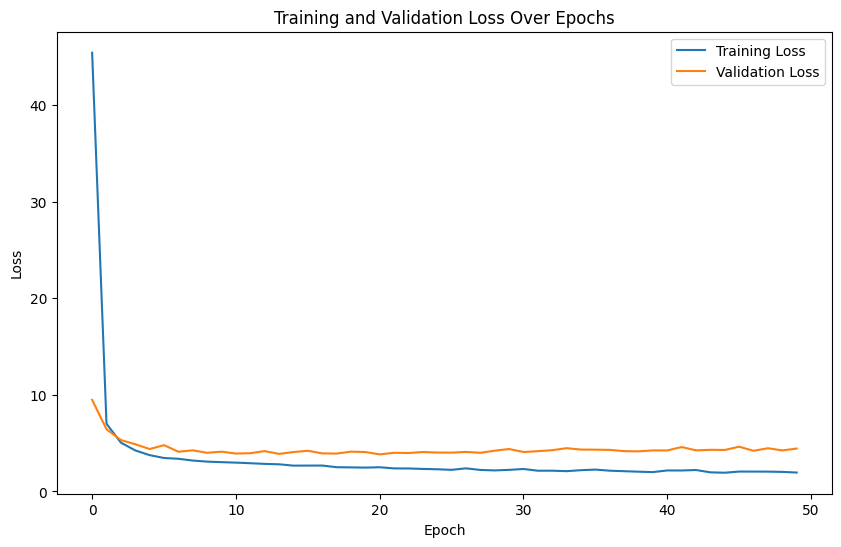

In [12]:
# Train the model
history_test = model_test.fit(
  X_train, y_train,
  validation_data=(X_holdout, y_holdout),
  batch_size=32,
  epochs=50,
  verbose=1,
)

# Plot the history over the epochs
plt.figure(figsize=(10, 6))
plt.plot(history_test.history['loss'], label='Training Loss')
plt.plot(history_test.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()


In [13]:
# Hyperparameter Sweep
# --- Hyperparameter grid ---
param_grid = {
    "depth":         [2, 4, 8],
    "width":         [64, 128],
    "batch_size":    [32, 64],
    "epochs":        [50, 100],
    "learning_rate": [1e-2, 1e-3],
    "activation":    ["relu", "sigmoid"],
}

# Generate all combinations
keys, values = zip(*param_grid.items())
combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

# Storage for results
results = []

# Early stopping callback to speed up training
# early_stop = EarlyStopping(
#     monitor="val_loss",
#     patience=5,
#     restore_best_weights=True,
#     verbose=0
# )

best_model = None
best_val_loss = float("inf")

# Sweep
for params in combinations:
    print("Training with:", params)
    # Build a fresh model
    model = create_nn(
        input_shape = X_train.shape[1:],
        width          = params["width"],
        depth          = params["depth"],
        activation     = params["activation"],
        learning_rate  = params["learning_rate"],
        # optimizer_name = params["optimizer_name"],
        # loss_name      = params["loss_name"],
    )

    # Train
    history = model.fit(
        X_train, y_train,
        validation_data=(X_holdout, y_holdout),
        batch_size   = params["batch_size"],
        epochs       = params["epochs"],
        # callbacks    = [early_stop],
        verbose      = 0,  # set to 1 if you want per‑epoch logs
    )

    # Record final validation loss & mse
    final_val_loss = history.history["val_loss"][-1]
    # final_val_mse  = history.history["val_mse"][-1]

    print(f"Final validation loss: {final_val_loss:.4f}")
    # print(f"Final validation mse: {final_val_mse:.4f}")

    if final_val_loss < best_val_loss:
        best_val_loss = final_val_loss
        best_model = model

    results.append({
        **params,
        "final_val_loss": final_val_loss,
        # "final_val_mse":  final_val_mse,
        # "epochs_trained": len(history.history["loss"])
    })

# Summarize in a DataFrame
results1_df = pl.DataFrame(results).sort("final_val_loss")
print(results1_df)

Training with: {'depth': 2, 'width': 64, 'batch_size': 32, 'epochs': 50, 'learning_rate': 0.01, 'activation': 'relu'}
Final validation loss: 3.5167
Training with: {'depth': 2, 'width': 64, 'batch_size': 32, 'epochs': 50, 'learning_rate': 0.01, 'activation': 'sigmoid'}
Final validation loss: 3.2636
Training with: {'depth': 2, 'width': 64, 'batch_size': 32, 'epochs': 50, 'learning_rate': 0.001, 'activation': 'relu'}
Final validation loss: 4.2204
Training with: {'depth': 2, 'width': 64, 'batch_size': 32, 'epochs': 50, 'learning_rate': 0.001, 'activation': 'sigmoid'}
Final validation loss: 3.6359
Training with: {'depth': 2, 'width': 64, 'batch_size': 32, 'epochs': 100, 'learning_rate': 0.01, 'activation': 'relu'}
Final validation loss: 3.3720
Training with: {'depth': 2, 'width': 64, 'batch_size': 32, 'epochs': 100, 'learning_rate': 0.01, 'activation': 'sigmoid'}
Final validation loss: 3.2881
Training with: {'depth': 2, 'width': 64, 'batch_size': 32, 'epochs': 100, 'learning_rate': 0.001, '

In [14]:
# Best parameters
best_params = results1_df.sort("final_val_loss").head(3).to_dict(as_series=True)
# Save best paramters to variables
best_width = best_params["width"][0]
best_depth = best_params["depth"][0]
best_activation = best_params["activation"][0]
best_learning_rate = best_params["learning_rate"][0]
best_batch_size = best_params["batch_size"][0]
best_epochs = best_params["epochs"][0]

print("Best parameters:")
print(f'Width: {best_width}')
print(f'Depth: {best_depth}')
print(f'Activation: {best_activation}')
print(f'Learning rate: {best_learning_rate}')
print(f'Batch size: {best_batch_size}')
print(f'Epochs: {best_epochs}')


# Save best performing model
print("Final model without dropout")
model1 = best_model
model1.summary()



Best parameters:
Width: 128
Depth: 4
Activation: relu
Learning rate: 0.01
Batch size: 32
Epochs: 50
Final model without dropout


Model: "functional_99"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer_49 (InputLayer)     │ (None, 55)                │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_180 (Dense)               │ (None, 128)               │      7,168 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_181 (Dense)               │ (None, 128)               │     16,512 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_182 (Dense)               │ (None, 128)               │     16,512 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_183 (Dense)               │ (None, 128)               │     16,512 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_184 (Dense)               │ (None, 1)                 │        129 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 170,501 (666.02 KB)

 Trainable params: 56,833 (222.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 113,668 (444.02 KB)

MODELS WITH DROPOUT AND REGULARIZATION

In [15]:
# Create a test model with dropout and regularization
model_test2 = create_nn(
  X_train.shape[1:],
  width=best_params["width"][0],
  depth=best_params["depth"][0],
  activation=best_params["activation"][0],
  learning_rate=best_params["learning_rate"][0],
  dropout=0.2,
  regularization_name="l2",
  regularization_rate=0.001,
)
model_test2.summary()

Model: "functional_195"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer_97 (InputLayer)     │ (None, 55)                │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_548 (Dense)               │ (None, 128)               │      7,168 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout (Dropout)               │ (None, 128)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_549 (Dense)               │ (None, 128)               │     16,512 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_1 (Dropout)             │ (None, 128)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_550 (Dense)               │ (None, 128)               │     16,512 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_2 (Dropout)             │ (None, 128)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_551 (Dense)               │ (None, 128)               │     16,512 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_552 (Dense)               │ (None, 1)                 │        129 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 56,833 (222.00 KB)

 Trainable params: 56,833 (222.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 326.6849 - val_loss: 3.2581
Epoch 2/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.4495 - val_loss: 3.2555
Epoch 3/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.5032 - val_loss: 3.2504
Epoch 4/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.1873 - val_loss: 3.2946
Epoch 5/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.2392 - val_loss: 3.2382
Epoch 6/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.0876 - val_loss: 3.2877
Epoch 7/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.2409 - val_loss: 3.2348
Epoch 8/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.3358 - val_loss: 3.2513
Epoch 9/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.1823 - val_loss: 3.2451
Epoch 10/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.1885 - val_loss: 3.2532
Epoch 11/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.0869 - val_loss: 3.2276
Epoch 12/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/s

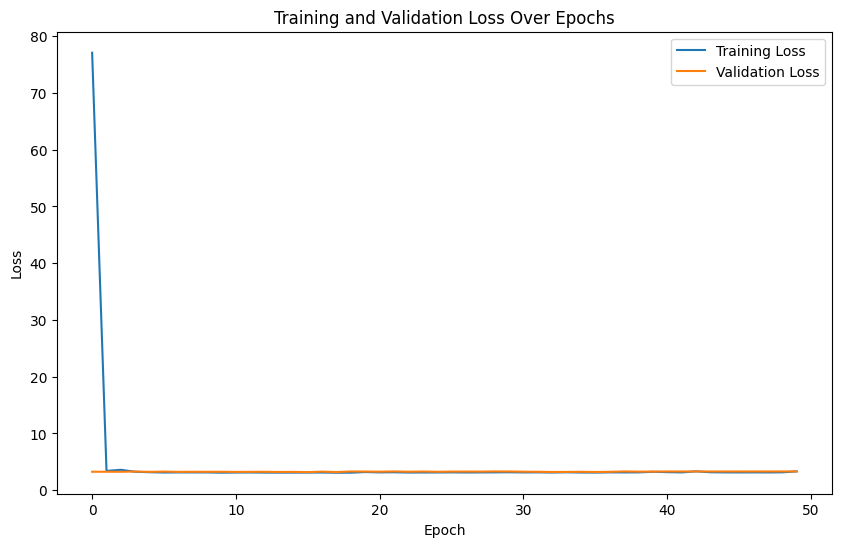

In [16]:
history_test2 = model_test2.fit(
  X_train, y_train,
  validation_data=(X_holdout, y_holdout),
  batch_size=best_params["batch_size"][0],
  epochs=best_params["epochs"][0],
  verbose=1,
)

# Plot the history
plt.figure(figsize=(10, 6))
plt.plot(history_test2.history['loss'], label='Training Loss')
plt.plot(history_test2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()


In [17]:
# Hyperparameter Sweep
# --- Hyperparameter grid ---
param_grid = {
    "dropout":  [0.0, 0.1, 0.2, 0.3, 0.4, 0.5],
    "regularization_name":     ["l1", "l2"],
    "regularization_rate":     [0.01, 0.001, 0.0001],
}

# Generate all combinations
keys, values = zip(*param_grid.items())
combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

# Storage for results
results = []

best_model2 = None
best_val_loss2 = float("inf")

# Early stopping callback to speed up training
# early_stop = EarlyStopping(
#     monitor="val_loss",
#     patience=5,
#     restore_best_weights=True,
#     verbose=0
# )

# Sweep
for params in combinations:
    print("Training with:", params)

    # Build a fresh model
    model = create_nn(
        input_shape = X_train.shape[1:],
        width          = best_width,
        depth          = best_depth,
        activation     = best_activation,
        learning_rate  = best_learning_rate,
        dropout        = params["dropout"],
        regularization_name = params["regularization_name"],
        regularization_rate = params["regularization_rate"],
    )

    # Train
    history = model.fit(
        X_train, y_train,
        validation_data=(X_holdout, y_holdout),
        batch_size   = best_batch_size,
        epochs       = best_epochs,
        # callbacks    = [early_stop],
        verbose      = 0,  # set to 1 if you want per‑epoch logs
    )

    # Record final validation loss & mse
    final_val_loss = history.history["val_loss"][-1]

    print(f"Final validation loss: {final_val_loss:.4f}")

    if final_val_loss < best_val_loss2:
        best_val_loss2 = final_val_loss
        best_model2 = model

    results.append({
        **params,
        "final_val_loss": final_val_loss,
    })

# Summarize in a DataFrame
results2_df = pl.DataFrame(results).sort("final_val_loss")
print(results2_df)

Training with: {'dropout': 0.0, 'regularization_name': 'l1', 'regularization_rate': 0.01}
Final validation loss: 3.2871
Training with: {'dropout': 0.0, 'regularization_name': 'l1', 'regularization_rate': 0.001}
Final validation loss: 3.3081
Training with: {'dropout': 0.0, 'regularization_name': 'l1', 'regularization_rate': 0.0001}
Final validation loss: 3.2940
Training with: {'dropout': 0.0, 'regularization_name': 'l2', 'regularization_rate': 0.01}
Final validation loss: 3.2987
Training with: {'dropout': 0.0, 'regularization_name': 'l2', 'regularization_rate': 0.001}
Final validation loss: 3.2868
Training with: {'dropout': 0.0, 'regularization_name': 'l2', 'regularization_rate': 0.0001}
Final validation loss: 3.2708
Training with: {'dropout': 0.1, 'regularization_name': 'l1', 'regularization_rate': 0.01}
Final validation loss: 3.2827
Training with: {'dropout': 0.1, 'regularization_name': 'l1', 'regularization_rate': 0.001}
Final validation loss: 3.2379
Training with: {'dropout': 0.1, '

In [20]:
# Best parameters
best_params2 = results2_df.sort("final_val_loss").head(1).to_dict(as_series=True)
print("Best parameters:")
print(f'Dropout: {best_params2["dropout"][0]}')
print(f'Regularization name: {best_params2["regularization_name"][0]}')
print(f'Regularization rate: {best_params2["regularization_rate"][0]}')


# Save best performing model
print("Final model with dropout")
model2 = best_model2
model2.summary()

Best parameters:
Dropout: 0.1
Regularization name: l2
Regularization rate: 0.001
Final model with dropout


Model: "functional_217"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer_108 (InputLayer)    │ (None, 55)                │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_603 (Dense)               │ (None, 128)               │      7,168 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_15 (Dropout)            │ (None, 128)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_604 (Dense)               │ (None, 128)               │     16,512 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_16 (Dropout)            │ (None, 128)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_605 (Dense)               │ (None, 128)               │     16,512 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_17 (Dropout)            │ (None, 128)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_606 (Dense)               │ (None, 128)               │     16,512 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_607 (Dense)               │ (None, 1)                 │        129 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 170,501 (666.02 KB)

 Trainable params: 56,833 (222.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 113,668 (444.02 KB)

In [23]:
# Test set
y_pred_baseline = baseline_model.predict(X_test)
mse_baseline = mean_squared_error(y_test, y_pred_baseline)
print(f"Baseline (Dummy Regressor) MSE: {mse_baseline}")

model1_mse = model1.evaluate(X_test, y_test, verbose=1)
print(f"Model 1 loss: {model1_mse:.4f}")

model2_mse = model2.evaluate(X_test, y_test, verbose=1)
print(f"Model 2 loss: {model2_mse:.4f}")

Baseline (Dummy Regressor) MSE: 3.075215639745927
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 3.3638
Model 1 loss: 3.0846
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 3.2467
Model 2 loss: 3.0719


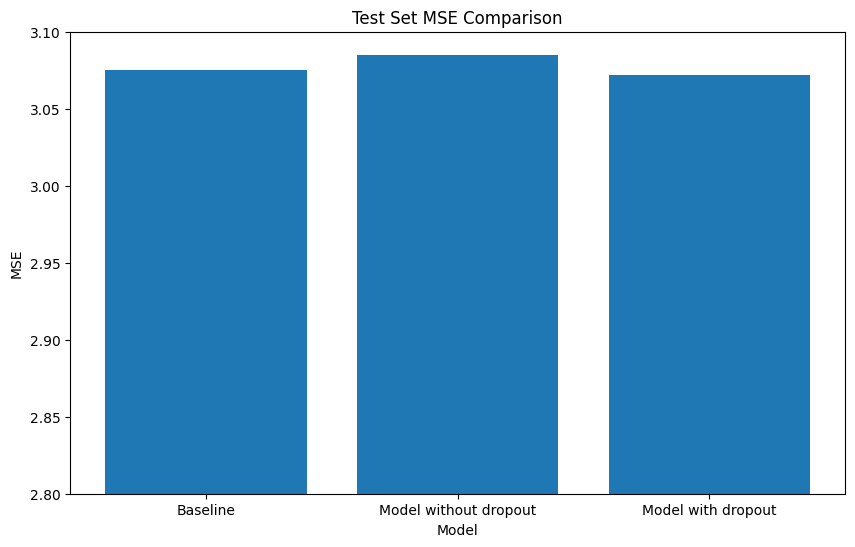

In [26]:
# Graph the test set MSE results
plt.figure(figsize=(10, 6))
plt.bar(
    ["Baseline", "Model without dropout", "Model with dropout"],
    [mse_baseline, model1_mse, model2_mse],
)
plt.xlabel("Model")
plt.ylabel("MSE")
plt.title("Test Set MSE Comparison")

# y axis shorten from 2.8 to 3.1
plt.ylim(2.8, 3.1)
plt.show()